## Labeling Reddit Mental Health Posts with Clustering, Topic Modeling, and Human Interpretation

### 0. Data prep

In [ ]:
# Import libraries
from data_utils import load_data, preprocess_text, split_data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [19]:
# Load data, preprosessing
df = load_data("solomonk/reddit_mental_health_posts")
df['processed_body'] = df['body'].apply(preprocess_text)
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url,processed_body
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.0,https://www.reddit.com/r/ADHD/comments/rmbjwb/...,"[months, ago, accepted, full, time, software, ..."
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.0,https://www.reddit.com/r/ADHD/comments/rmbd1y/...,"[hey, guys, curious, anyone, else, issue, me, ..."
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.0,https://www.reddit.com/r/ADHD/comments/rmbbvu/...,"[6, exams, next, 2, weeks, one, monday, havent..."
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.0,https://www.reddit.com/r/ADHD/comments/rmba1t/...,"[anyone, struggling, addadhd, thats, interesti..."
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.0,https://www.reddit.com/r/ADHD/comments/rmb8lm/...,"[whenever, get, hungry, never, eat, know, eat,..."


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87078 entries, 0 to 87077
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   author          87078 non-null  object 
 1   body            87078 non-null  object 
 2   created_utc     87078 non-null  object 
 3   id              87078 non-null  object 
 4   num_comments    87078 non-null  int64  
 5   score           87078 non-null  int64  
 6   subreddit       87078 non-null  object 
 7   title           87078 non-null  object 
 8   upvote_ratio    87078 non-null  float64
 9   url             87078 non-null  object 
 10  processed_body  87078 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 7.3+ MB


In [21]:
# Save processed data
df.to_csv('processed_data.csv', index=False)

---

### 1. Baseline model: Clustering

TF-IDF + KMeans clustering for different k:
- TF-IDF convert post to vector
- Kemans: 1000-d space, group based on euc distance
    - 1000 max_feature typically capture enough signal for medium length text
<br>

Reasons to choose this baseline:
- lightweight but strong methods
- No fancy modeling assumptions
- Comparable to LDA (that I plan to do later)

Evaluating different k to select the best one for LDA: 
<br><br>
**Silhouette score:** how well each datapoint fits within its assigned cluster
- (-1, 1); 1: perfect clustering; 0: borderline; -1: bad clustering
- We want it to be close to one
<br>

**WCSS (within cluster sum of sqs):** how compact the clusters are
- sum of sum of sq distances between each point
- We want it to be lower/closer to 0 -> more compact/tight

In [22]:
# Prepare training text for TF-IDF
train_texts = [' '.join(words) for words in df['processed_body']]

# Try different numbers of clusters
cluster_range = [5, 10, 15, 20]

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(train_texts)

silhouette_scores = []
wcss_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)
    sil_score = silhouette_score(X_tfidf, labels)
    wcss = kmeans.inertia_
    silhouette_scores.append(sil_score)
    wcss_scores.append(wcss)
    print(f"k={k} -> Silhouette Score: {sil_score:.4f}, WCSS: {wcss:.2f}")

k=5 -> Silhouette Score: 0.0055, WCSS: 79138.09
k=10 -> Silhouette Score: 0.0073, WCSS: 78125.70
k=15 -> Silhouette Score: 0.0075, WCSS: 77490.40
k=20 -> Silhouette Score: 0.0084, WCSS: 77016.15


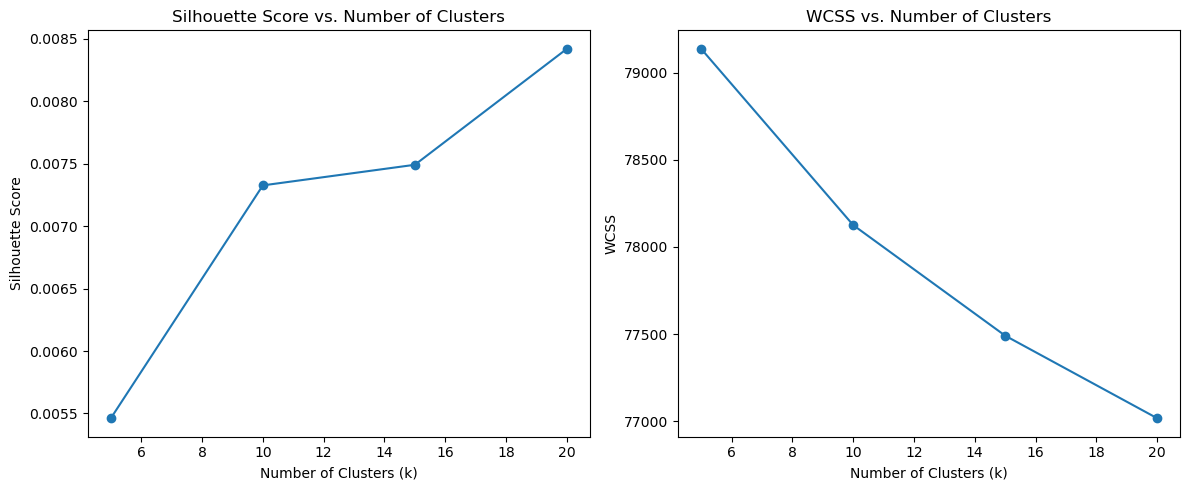

In [23]:
# Plot silhouette scores and WCSS
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, wcss_scores, marker='o')
plt.title('WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

plt.tight_layout()
plt.show()

Pretty bad results but it's not surprising since Reddit post data is noisy:
- Silhouette barely improves as k increases, WCSS decreases very slowly
- So the baseline is not good enough, and the posts have a lot of overlapping vocab
- Also tells us that increasing k won't help much

I will choose k=10 for LDA because:
- 5 are too few topics for a complicated theme
- But too many topics did not help, as seen in the results above
- So 10 is a reasonable middle ground
- Although Kmeans and LDA functions differently, but I mainly use k here to keep the comparison cohesive (that being said it's an important reminder)

Also here's a visualization for k=10 KMeans results (we can't visualize 1000-d so I used PCA to reduced it to 2-d), tho it probably looks even worse

[5 4 4 5 4 2 2 2 2 7]
[0.01244591 0.01031458]
Total variance explained: 0.0228


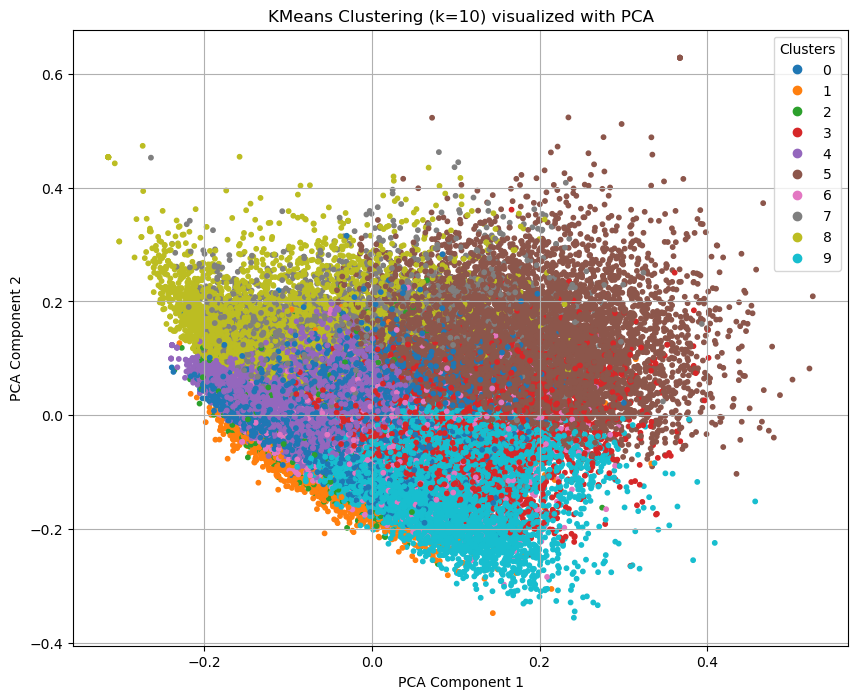

In [24]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Redo KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tfidf)
print(kmeans_labels[:10])  # Check first few labels

# Reduce dimensionality with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())  # Note: X_tfidf needs to be dense (.toarray())
print(pca.explained_variance_ratio_)
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Scatter plot colored by cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=10)
plt.title('KMeans Clustering (k=10) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

---
### 2. Topic Modeling: LDA
**Latent Dirichlet Allocation**
- a probabilistic model used for topic modeling
- understand the "latent" or hidden structure of text by finding groups of words that frequently appear together in different documents

Why LDA?
- More soft (captures latent structures)
- More flexible (assuming each post belong partially to multiple topics)
- Therefore it's good for our messy and overlapping text data
- Also good visualizations!

In [25]:
# for LDA:
from pprint import pprint # Gensim
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from sklearn.model_selection import KFold
from itertools import product

In [26]:
labeled_df = pd.read_csv('processed_data.csv')
dictionary = Dictionary(df['processed_body'])
corpus = [dictionary.doc2bow(post) for post in df['processed_body']]

lda = LdaModel(
               corpus=corpus,
               id2word=dictionary,
               num_topics=10, # k=10 as previously discussed
               alpha="auto", # Prior on document-topic distribution
               eta="auto", # Prior on topic-word distribution
               random_state=42,
               passes=5,
               iterations=100)

print("Topics discovered by LDA model:")
pprint(lda.print_topics(num_words=10))

Topics discovered by LDA model:
[(0,
  '0.018*"car" + 0.012*"door" + 0.010*"assault" + 0.009*"room" + 0.008*"rape" '
  '+ 0.008*"eyes" + 0.007*"back" + 0.007*"touch" + 0.007*"face" + '
  '0.007*"body"'),
 (1,
  '0.034*"sleep" + 0.033*"night" + 0.025*"day" + 0.017*"days" + 0.016*"last" + '
  '0.015*"started" + 0.014*"hours" + 0.013*"panic" + 0.013*"week" + '
  '0.013*"ago"'),
 (2,
  '0.034*"work" + 0.024*"get" + 0.019*"time" + 0.017*"cant" + 0.013*"day" + '
  '0.012*"need" + 0.011*"things" + 0.008*"hours" + 0.008*"every" + '
  '0.008*"anything"'),
 (3,
  '0.214*"im" + 0.113*"dont" + 0.078*"ive" + 0.035*"didnt" + 0.019*"like" + '
  '0.018*"ill" + 0.017*"doesnt" + 0.016*"feel" + 0.015*"know" + 0.015*"wasnt"'),
 (4,
  '0.025*"food" + 0.021*"clean" + 0.021*"flashback" + 0.019*"hands" + '
  '0.018*"eat" + 0.018*"bathroom" + 0.017*"room" + 0.017*"eating" + '
  '0.016*"shower" + 0.015*"house"'),
 (5,
  '0.019*"like" + 0.016*"feel" + 0.013*"me" + 0.013*"know" + 0.010*"get" + '
  '0.010*"want" +

In [27]:
# a measure of how good the model is - the lower the better
print('Perplexity: ', lda.log_perplexity(corpus))

Perplexity:  -8.171560973989045


Not that good, but reasonable?

In [28]:
# Visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, dictionary=dictionary, corpus=corpus)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.116478  0.021720       1        1  45.629567
6      0.177666  0.072057       2        1  16.453019
7      0.143284 -0.140034       3        1  11.530428
9     -0.030855 -0.181144       4        1   5.569785
2      0.007279  0.022716       5        1   5.166221
3      0.124570  0.340688       6        1   4.345344
8      0.115866 -0.127020       7        1   3.852616
1     -0.065236 -0.129113       8        1   3.198017
0     -0.263526  0.031263       9        1   2.879775
4     -0.325525  0.088867      10        1   1.375229, topic_info=           Term           Freq          Total Category  logprob  loglift
32           im   72211.000000   72211.000000  Default  30.0000  30.0000
11         dont   37983.000000   37983.000000  Default  29.0000  29.0000
35          ive   26372.000000   26372.000000  Default  28.0000  28.0000
2821       ptsd   37582.000000   37582.000000  Default  27.0000  27.0000
42         like  103738.000000  103738.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
574         bed     754.399071    5741.307443  Topic10  -4.9524   2.2570
79    apartment     576.477325    1890.046598  Topic10  -5.2214   3.0991
1158        use     691.095329    6027.021996  Topic10  -5.0401   2.1208
102        home     729.990922   11834.376758  Topic10  -4.9853   1.5008
1005        put     666.067884    8415.302691  Topic10  -5.0770   1.7501

[736 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
136        1  0.226289       2
136        2  0.007870       2
136        3  0.136640       2
136        4  0.208382       2
136        5  0.024180       2
...      ...       ...     ...
1816       6  0.938579   youre
1960       6  0.997219   youve
1960       9  0.001874   youve
12720      8  0.993894     yrs
1511       7  0.999566  zoloft

[2096 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 10, 3, 4, 9, 2, 1, 5])

In [29]:
pyLDAvis.save_html(vis, 'lda_vis.html')

Not doing hyperparameter tuning here (taking too much time, but I have the code in `lda_hyperparams_tuning.py` for reference), directly moving into result interpretation

After inspecting the top keywords of each topic discovered by the final LDA model, the following interpretations are assigned:

| Topic ID | Top Keywords | Interpretation |
|:---|:---|:---|
| 0 | car, door, assault, room, rape, eyes, back, touch, face, body | **Physical Assault / Trauma** |
| 1 | sleep, night, day, days, last, started, hours, panic, week, ago | **Sleep Disruption & Panic Symptons** |
| 2 | work, get, time, cant, day, need, things, hours, every, anything | **Work Avoidance and Exhaustion** |
| 3 | im, dont, ive, didnt, like, ill, doesnt, feel, know, wasnt | **Identity and Emotional Denial** |
| 4 | food, clean, flashback, hands, eat, bathroom, room, eating, shower, house | **Flashbacks & Avoidance Behaviors** |
| 5 | like, feel, me, know, get, want, even, time, cant, really | **General Emotional Struggle** |
| 6 | ocd, like, thoughts, anyone, something, else, think, things, also, it| **OCD & Intrusive Thoughts** |
| 7 | ptsd, trauma, therapist, therapy, help, mental, health, would, diagnosed, work | **PTSD Diagnosis & Mental Health Services** |
| 8 | anxiety, medication, meds, taking, depression, emdr, symptoms, psychiatrist, take, years | **Medication & Psychiatric Care** |
| 9 | school, year, years, dad, mom, got, parents, home, job, old | **Family & Developmental History** |


- **Specific and Strong Topics**:
  - Topics like PTSD and Therapy (7), Medication and Psychiatry (8), OCD (6), and Sleep and Panic (1) are well-formed and align with known mental health domains
  - Topic 0 and Topic 4 both capture trauma but in different ways
  - Topic 3 and Topic 5 are emotionally heavy but vague

Now attaching these topics back to my train_df:
- First need to select the dominant topic for each document
- Add as train_df['dominant_topic']
- Create mapping

In [30]:
# Assign dominant topic
train_doc_topics = []
for bow in corpus:  
    topic_dist = lda.get_document_topics(bow)
    dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
    train_doc_topics.append(dominant_topic)

df['dominant_topic'] = train_doc_topics

# Mapping
topic_label_map = {
    0: "Physical/Sexual Trauma",
    1: "Sleep Disruption & Panic Symptons",
    2: "Work Avoidance and Exhaustion",
    3: "Identity and Emotional Denial",
    4: "Flashbacks & Avoidance Behaviors",
    5: "General Emotional Struggle",
    6: "OCD & Intrusive Thoughts",
    7: "PTSD Diagnosis & Mental Health Services",
    8: "Medication & Psychiatric Care",
    9: "Family & Developmental History"
}

# Apply mapping
df['topic_label'] = df['dominant_topic'].map(topic_label_map)

# Check first few rows
df[['body', 'dominant_topic', 'topic_label']].head()


,body,dominant_topic,topic_label
0,A few months ago I was accepted into this full...,5,General Emotional Struggle
1,"Hey guys, I was curious if anyone else has the...",5,General Emotional Struggle
2,\n\ni have 6 exams in the next 2 weeks one of...,5,General Emotional Struggle
3,Is there anyone out there that is struggling w...,7,PTSD Diagnosis & Mental Health Services
4,"Whenever I get hungry, I never eat because I d...",5,General Emotional Struggle


In [32]:
df[['body', 'dominant_topic', 'topic_label']].to_csv('labeled_data.csv', index=False)

----
### 3. Labeling: Human Interpretation

Created a new dataset with posts and topic labels (generated by both clustering + human interpretation of the clustering). Now take a look at the result dataset "labeled_data.csv":

In [33]:
# Load again
labeled_df = pd.read_csv('labeled_data.csv')

# Overview
print("Shape of the dataset:", labeled_df.shape)
display(labeled_df.head())

# Topic distribution
print("\nTopic distribution (by ID):")
display(labeled_df['dominant_topic'].value_counts())

print("\nTopic distribution (by label):")
display(labeled_df['topic_label'].value_counts())

# Text length stats
labeled_df['text_length'] = labeled_df['body'].apply(lambda x: len(x.split()))
print("\nAverage text length:", labeled_df['text_length'].mean())
print("Median text length:", labeled_df['text_length'].median())

Shape of the dataset: (87078, 3)


,body,dominant_topic,topic_label
0,A few months ago I was accepted into this full...,5,General Emotional Struggle
1,"Hey guys, I was curious if anyone else has the...",5,General Emotional Struggle
2,\n\ni have 6 exams in the next 2 weeks one of...,5,General Emotional Struggle
3,Is there anyone out there that is struggling w...,7,PTSD Diagnosis & Mental Health Services
4,"Whenever I get hungry, I never eat because I d...",5,General Emotional Struggle



Topic distribution (by ID):


dominant_topic
5    64793
6    10426
7     4817
8     2846
2     2165
1      953
9      656
0      221
4      119
3       82
Name: count, dtype: int64


Topic distribution (by label):


topic_label
General Emotional Struggle                 64793
OCD & Intrusive Thoughts                   10426
PTSD Diagnosis & Mental Health Services     4817
Medication & Psychiatric Care               2846
Work Avoidance and Exhaustion               2165
Sleep Disruption & Panic Symptons            953
Family & Developmental History               656
Physical/Sexual Trauma                       221
Flashbacks & Avoidance Behaviors             119
Identity and Emotional Denial                 82
Name: count, dtype: int64


Average text length: 180.69925813638346
Median text length: 124.0


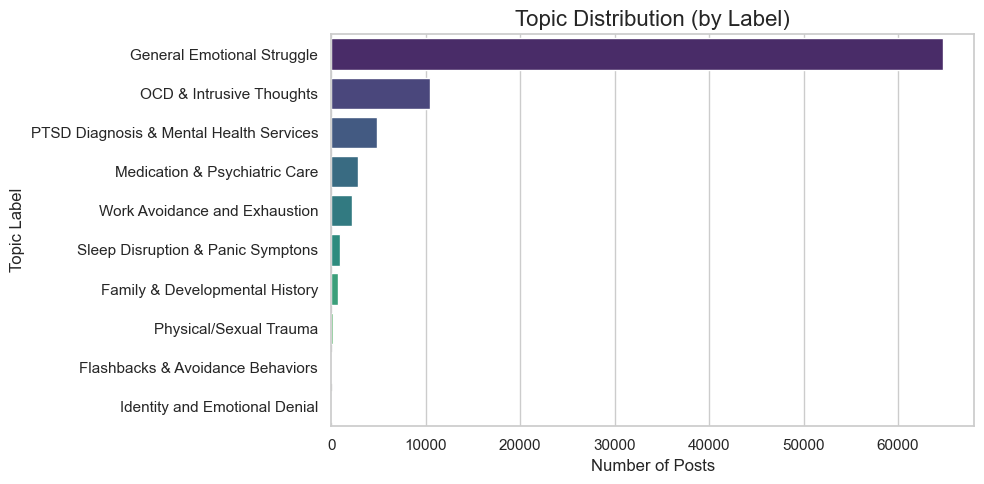

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Bar Plot: Topic distribution by Label
plt.figure(figsize=(10,5))
sns.countplot(data=labeled_df, y='topic_label', order=labeled_df['topic_label'].value_counts().index, palette="viridis")
plt.title('Topic Distribution (by Label)', fontsize=16)
plt.xlabel('Number of Posts')
plt.ylabel('Topic Label')
plt.tight_layout()
plt.savefig('results_visualizations/topic_distribution_bar.png') 
plt.show()


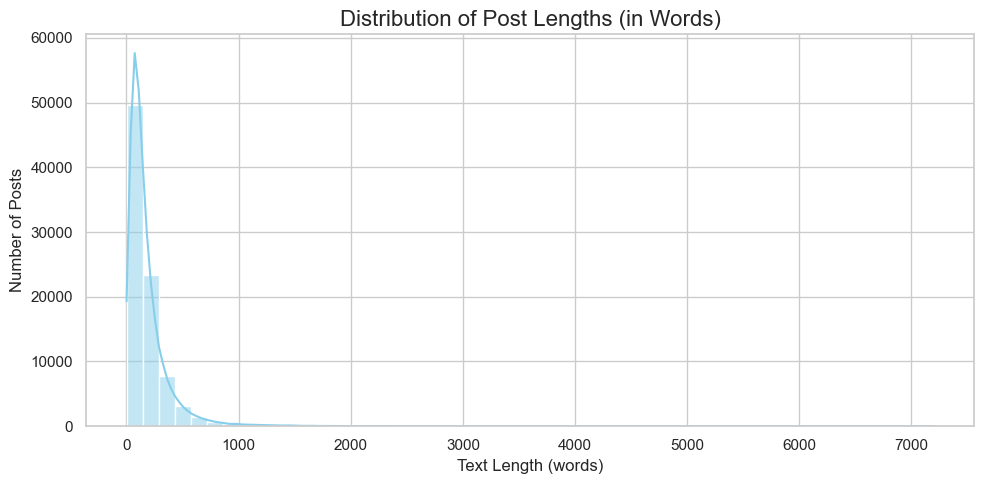

In [39]:
# Histogram: Text length distribution
plt.figure(figsize=(10,5))
sns.histplot(labeled_df['body'].apply(lambda x: len(x.split())), bins=50, kde=True, color="skyblue")
plt.title('Distribution of Post Lengths (in Words)', fontsize=16)
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.savefig('results_visualizations/post_length_distribution.png') 
plt.show()

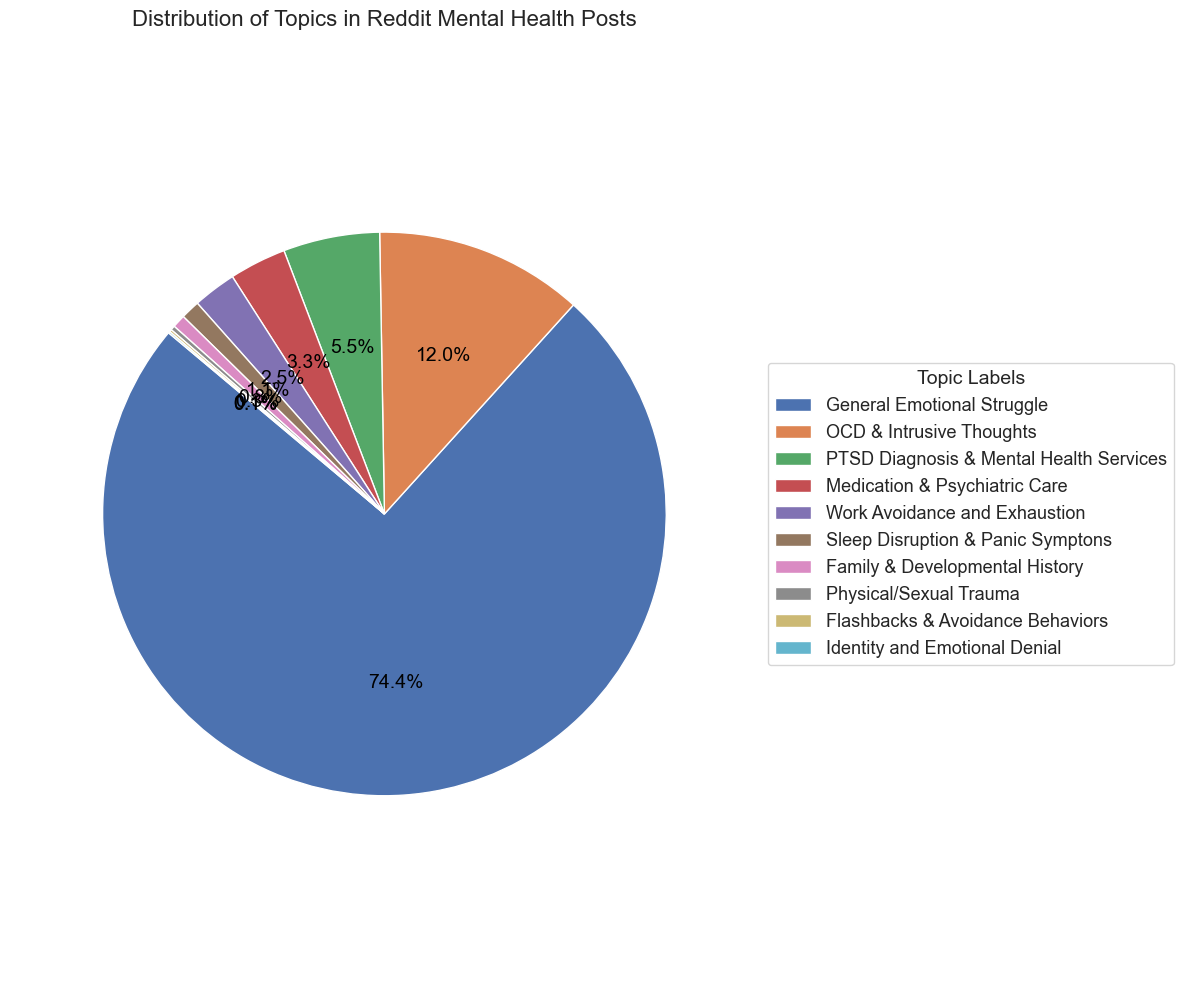

In [41]:
# Pie chart

topic_counts = labeled_df['topic_label'].value_counts()
#colors = colors=sns.color_palette('viridis', len(topic_counts))

fig, ax = plt.subplots(figsize=(12, 10))

wedges, texts, autotexts = ax.pie(
    topic_counts,
    autopct='%1.1f%%',
    startangle=140,
    #colors=colors,
    textprops=dict(color="black", fontsize=14)
)

ax.legend(
    topic_counts.index,
    title="Topic Labels",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=13,
    title_fontsize=14
)

ax.axis('equal')

plt.title('Distribution of Topics in Reddit Mental Health Posts', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('results_visualizations/topic_distribution_pie.png') 
plt.show()
